# Deep Image Prior (DIP) for PAM
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from keras.optimizers import Adam
import os

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 0  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Step 1: Mode Selection

In [3]:
REG_TRAINING = True # Train the model regularly on a single image

NOISE_REG_EXAM = False  # Examine which noise regularization works best
BATCH_MODE = False  # 

SAVE_MODEL = True  # Save trained model and input noise
SAVE_LOSS = True
SAVE_OUTPUT = True  # Save auxillary info (training time and noise reg) output image, 
                    # with corrected image in the 2nd channel

### Step 2: Params Input and Pre-processing

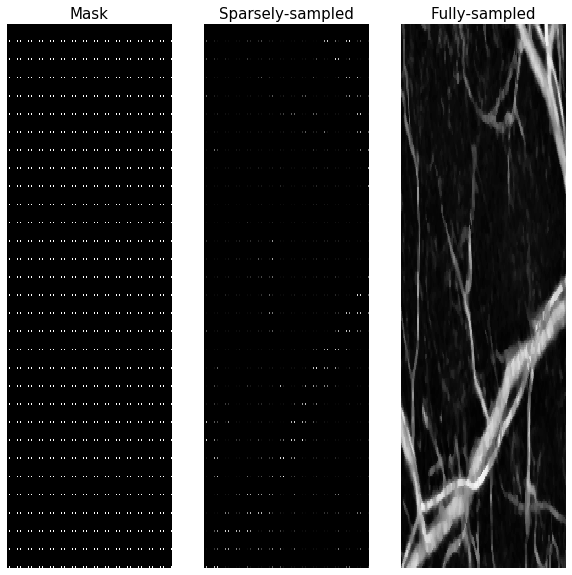

In [4]:
imgpath = './Data/'
imgname = '20190524_ear_drug   8_Image0_index0_pad_5-10'
imgsuffix = 'png'
if REG_TRAINING:
    im = cv2.imread(imgpath + imgname + '.' + imgsuffix)
    im, im_gt, im_masked, im_mask, im_down, factor = readImg(im)

    constructPlot(im, 
                  ['', 'Mask', 'Sparsely-sampled', 'Fully-sampled'], 
                  fsize=(10,10))
    
#     plt.imshow(im_down)
#     plt.show()

#     plt.imshow(im_masked)
#     plt.show()

In [5]:
if BATCH_MODE:
    imgpath = './Data/10_5'
    batch_range = [1, 30]

In [6]:
if NOISE_REG_EXAM:
    im, im_gt, im_masked, im_mask, im_down, factor = readImg(im)
    constructPlot(im, 
                  ['', 'Mask', 'Sparsely-sampled', 'Fully-sampled'], 
                  fsize=(10,10))
    noise_range = [0.01, 0.21]
#     noise_reg = np.linspace(noise_range[0], noise_range[1], num=31)
    noise_reg = np.arange(noise_range[0], noise_range[1], step=0.01)

In [7]:
im.shape

(300, 300, 3)

### CNN buildup partially contributed by deep prior implement by Kosugi: https://github.com/satoshi-kosugi/DeepImagePrior/blob/master/denoising.py

0.5332528287689341
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


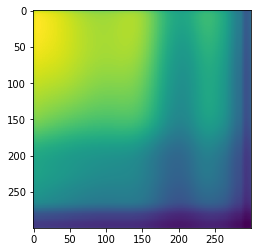

0
0.1005578536256828


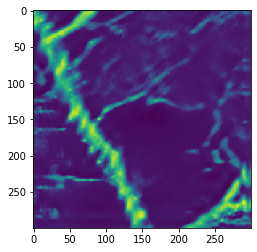

500
0.5594920621732706


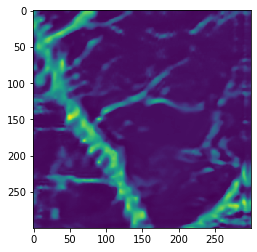

1000
0.6439501394327322


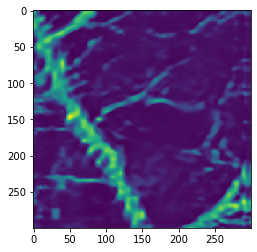

1500
0.6476888449051965


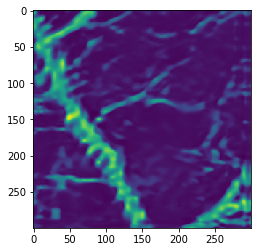

2000
0.6514812786245404


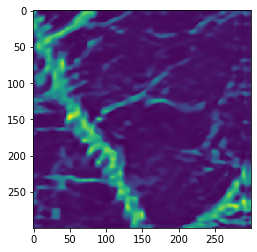

2500
0.650237889230901


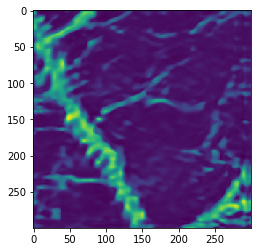

3000
0.6475833371326333


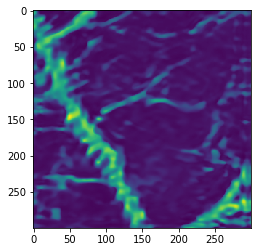

3500
0.6458754857648543


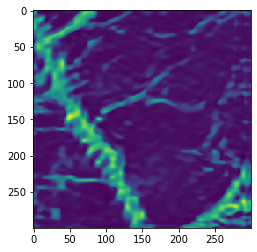

4000
0.643736577833689


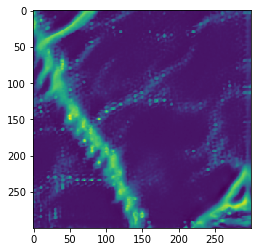

4500
0.5531344308579526
Done


In [8]:
# For regular training 
if REG_TRAINING:
    cur_ssim = ssim(im_down.astype(np.uint8), im_gt)
    print(str(cur_ssim))                                                            
    [sr_image, l, model, 
     totalTrainingTimeHr, 
     input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000, 
             noise_reg=0.07, show_output=True)
    print('Done')

In [9]:
# print(im_down.shape)

In [10]:
# For examining noise regularization
if NOISE_REG_EXAM:
    count = 1
    for ii in noise_reg:
        print('Current noise_reg: ' + str(ii) + '...')
        [sr_image, l, model, totalTrainingTimeHr, input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000,
                                                                             noise_reg=ii)
        temp = norm_uint8(sr_image)
        cur_ssim = ssim(temp, im_gt)
        cur_w = model.get_weights()
        if count > 1:
            if cur_ssim > np.max(ssim_rec[:, 1]):  # Record the best model and its output
                best_w = np.copy(cur_w)
                best_noise = np.copy(input_noise)
                best_sr_image = np.copy(sr_image)
                best_l = np.copy(l)
                best_reg = np.copy(ii)
                all_l = np.dstack((all_l, l))
                print('Best model is at noise reg ' + str(best_reg) + ' with SSIM = ', str(np.max(ssim_rec[:, 1])))
        else:
            ssim_rec = np.array([[ii, cur_ssim]])  # Initialize SSIM record matrix
            best_w = np.copy(cur_w)
            best_noise = np.copy(input_noise)
            best_sr_image = np.copy(sr_image)
            best_l = np.copy(l)
            best_reg = np.copy(ii)
            all_l = l
        ssim_rec = np.concatenate((ssim_rec, [[ii, cur_ssim]]), axis=0)
        if ii < noise_reg[-1]:
            K.clear_session()
        count += 1
    
    model.set_weights(best_w)
    sr_image = np.squeeze(best_sr_image)
    input_noise = best_noise
    l = best_l
    np.savetxt(imgpath + imgname + '_noiseRegvsSSIM.txt', np.asarray(ssim_rec))
    
    print('Best model is at noise reg ' + str(best_reg) + ' with SSIM = ', str(np.max(ssim_rec[:, 1])))
    
    plt.plot(ssim_rec[:,0], ssim_rec[:,1])
    plt.show()

### Step 3: Post-processing and Save Vars

In [11]:
sr_image = norm_uint8(sr_image)

In [12]:
# Assign output to the channels of the output image
im_out = np.dstack((im_mask, sr_image, im_gt))
# im_out = im_out.reshape((im_out.shape[1], im_out.shape[2], im_out.shape[0]))
im_mask.shape

(300, 300)

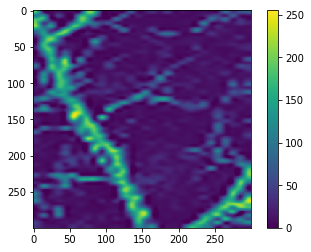

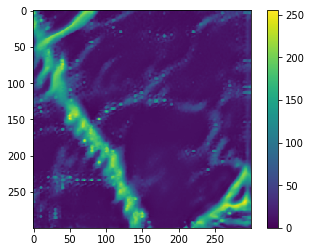

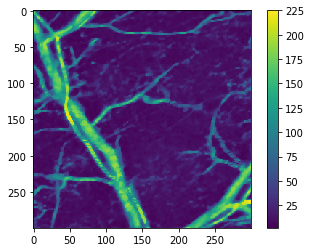

In [13]:
plt.imshow(norm_uint8(im_down))
plt.colorbar()
plt.show()
plt.imshow(im_out[:, :, 1])
plt.colorbar()
plt.show()
plt.imshow(im_out[:, :, 2])
plt.colorbar()
plt.show()

In [14]:
np.max(im_down)

240

In [15]:
np.max(sr_image)

255

In [16]:
cur_ssim = ssim(im_out[:, :, 1], im_gt)
print(str(cur_ssim))
cur_ssim = ssim(norm_uint8(im_down), im_gt)
print(str(cur_ssim))

0.6332328960850324
0.5293229674423588


### Save model and image

In [17]:
if SAVE_MODEL:
    model.save(imgpath + '/output/' + imgname + '_2.h5')
    inputNoise = np.squeeze(input_noise)
    inputNoise = inputNoise.reshape((inputNoise.shape[0], inputNoise.shape[1]*inputNoise.shape[2]))
    np.savetxt(imgpath + '/output/' + imgname + '_inputNoise_2.txt', np.asarray(np.squeeze(inputNoise)))

In [18]:
if SAVE_OUTPUT:
    cv2.imwrite(imgpath + '/output/' + imgname + '_dip_out_2.png', im_out)
    np.savetxt(imgpath + '/output/' + imgname + '_Aux_2.txt', np.asarray([totalTrainingTimeHr]))

In [19]:
if SAVE_LOSS:
    np.savetxt(imgpath + '/output/' + imgname + '_loss_2.txt', np.asarray(l))

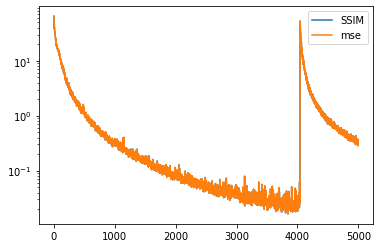

0.016328689


(5000, 2)

In [20]:
l_arr = np.asarray(l)
plt.plot(l)
plt.yscale('log')
plt.legend(['SSIM', 'mse', 'Sum'])
plt.show()
print(str(np.min(l)))
l_arr.shape

In [21]:
totalTrainingTimeHr

13.784650580088298

### Read corresponded DL image

In [22]:
dlpath = imgpath + 'deep_learning/'

In [23]:
im1 = cv2.imread(imgpath + imgname + '.' + imgsuffix)
dlim = cv2.imread(dlpath + imgname + '.' + imgsuffix)
dlim = cv2.resize(dlim, (im1.shape[1], im1.shape[0]))
print(dlim.shape)
axis1_range=[200, 600]
axis2_range=[300, 1400]
dlim = dlim[axis1_range[0]:axis1_range[1], axis2_range[0]:axis2_range[1], :]

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
plt.imshow(dlim)
plt.show()

In [ ]:
plt.imshow(im_gt)
plt.show()